### imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp
from hep_VQAE import CAE as cae
import h5py
import keras
import numpy as np
from tensorflow.keras.utils import Sequence
from matplotlib.colors import LogNorm

2022-09-09 15:32:13.045309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-09 15:32:13.045362: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/tom/.conda/envs/tfq/lib/python3.9/site-packages/cirq/ops/gateset.py:376: UserWarning: v0.14.1 is the last release `cirq.GlobalPhaseGate` is included by default. If you were relying on this behavior, you can include a `cirq.GlobalPhaseGate` in your `*gates`. If not, then you can ignore this warning. It will be removed in v0.16
  warnings.warn(
2022-09-09 15:32:16.741653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-09 15:32:16.741707: W tensorflow/

### load data 

In [6]:
ftrain = h5py.File("../../data/quark-gluon/quark-gluon_train-set_n793900.hdf5","r")
fdummy = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n10000.hdf5","r")
fval = h5py.File("../../data/quark-gluon/quark-gluon_test-set_n139306.hdf5","r")

In [26]:
x_train = ftrain.get('X_jets')
y_train = ftrain.get('y')

x_val = fval.get('X_jets')
y_val = fval.get('y')

#x_dummy = fdummy.get('X')
#y_dummy = fdummy.get('y')

x_val = fdummy.get('X')
y_val = fdummy.get('y')

### resize and safe to new file

In [27]:
num_splits = 10
batch_size = 512
events = x_train.shape[0]
num_batches = events // batch_size
batches_per_split = num_batches // num_splits

In [28]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):  # if value ist tensor
        value = value.numpy()  # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _float_feature(value):
    """Returns a floast_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))



def serialize_array(array):
    array = tf.io.serialize_tensor(array)
    return array

In [29]:

def parse_single_image(image, label):
    #define the dictionary -- the structure -- of our single example
    #encimg = tf.image.encode_png(image)
    
    data = {
        'raw_image': _bytes_feature(serialize_array(image)),
        #'raw_image': _bytes_feature(encimg),
        'label': _int64_feature(label)
    }

    #create an Example, wrapping the single features
    out = tf.train.Example(features=tf.train.Features(feature=data))

    return out

In [30]:
import tqdm
import os
def write_images_to_tfr(out_dir: str = "./tfrecords/"):
    os.makedirs(out_dir, exist_ok=True)
    #determine the number of shards (single TFRecord files) we need:  #determine how many tfr shards are needed

    file_count = 0

    for i in tqdm.tqdm(range(num_splits)):
        current_shard_name = "{}{}_{}.tfrecords".format(out_dir, i + 1, num_splits)
        writer = tf.io.TFRecordWriter(current_shard_name)
        samplecounter = i*batches_per_split*batch_size
        for j in range(batches_per_split):
            
            batch_x = x_train[samplecounter+j*batch_size:samplecounter+(j+1)*batch_size]
            batch_y = y_train[samplecounter+j*batch_size:samplecounter+(j+1)*batch_size]
            print(j,"/",batches_per_split,end="\r")
            for idx, batch in enumerate(zip(batch_x,batch_y)):
                out = parse_single_image(image=batch[0], label=int(batch[1]))
                writer.write(out.SerializeToString())
                

        writer.close()
    print(f"\nWrote {file_count} elements to TFRecord")
    return file_count

In [31]:
count = write_images_to_tfr()

  0%|                         | 0/10 [00:00<?, ?it/s]

 10%|█▍            | 1/10 [11:10<1:40:32, 670.29s/it]

 20%|██▊           | 2/10 [22:27<1:29:54, 674.30s/it]

 30%|████▏         | 3/10 [33:41<1:18:39, 674.20s/it]

 40%|█████▌        | 4/10 [44:50<1:07:12, 672.14s/it]

 50%|████████        | 5/10 [55:57<55:51, 670.37s/it]

 60%|████████▍     | 6/10 [1:07:03<44:34, 668.75s/it]

 70%|█████████▊    | 7/10 [1:17:57<33:12, 664.13s/it]

 80%|███████████▏  | 8/10 [1:28:51<22:01, 660.93s/it]

 90%|████████████▌ | 9/10 [1:39:42<10:57, 657.80s/it]

100%|█████████████| 10/10 [1:50:46<00:00, 664.66s/it]


Wrote 0 elements to TFRecord


In [15]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'label': tf.io.FixedLenFeature([], tf.int64),
        'raw_image': tf.io.FixedLenFeature([], tf.string),
    }

    content = tf.io.parse_single_example(element, data)

    label = content['label']
    raw_image = content['raw_image']

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[125, 125, 3])
    return (feature, label)

In [16]:
import glob
def get_dataset(tfr_dir: str = "/content/", pattern: str = "*.tfrecords"):
    files = glob.glob(os.path.join(tfr_dir, pattern), recursive=False)
    print(files)

    #create the dataset
    dataset = tf.data.TFRecordDataset(files)

    #pass every single feature through our mapping function
    dataset = dataset.map(
        parse_tfr_element
    )

    return dataset

In [17]:
dataset = get_dataset("./tfrecords")
dataset = dataset.batch(128)
dataset = dataset.map(lambda x, y:(tf.cast(x, tf.float32)/1.0, y))

['./tfrecords/7_10.tfrecords', './tfrecords/2_10.tfrecords', './tfrecords/5_10.tfrecords', './tfrecords/1_10.tfrecords', './tfrecords/9_10.tfrecords', './tfrecords/4_10.tfrecords', './tfrecords/3_10.tfrecords', './tfrecords/10_10.tfrecords', './tfrecords/8_10.tfrecords', './tfrecords/6_10.tfrecords']


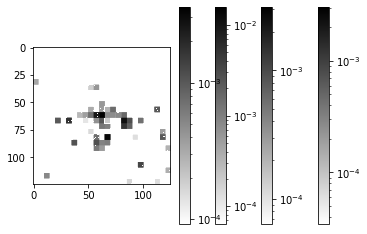

In [19]:
from matplotlib.colors import LogNorm
for images, labels in dataset.take(1):
    
    for i in range(4):
        plt.imshow(images[i][:,:,2].numpy(),cmap="binary",norm=LogNorm())
        plt.colorbar()